# Implementing Nonparametric Quantile Regression


_Thomas Wiemann_

_TA Discussion \# 5_  
_ECON 31740_  

_Feburary 14, 202_2  

## Section 0: Preliminaries

This section loads the necessary dependencies. The quantile regression methods are implemented in a custom package, ``MyMethods.jl``, which is readily available via https://github.com/thomaswiemann/MyMethods.jl. (See the ``README.md`` for installation instructions.) 

In [189]:
# Load custom package for basis functions. If not yet installed, run the following:
#    ``using Pkg; Pkg.add(PackageSpec(url="https://github.com/thomaswiemann/MyMethods.jl")))``.
using MyMethods

# Load additional dependencies
using Statistics
using DataFrames, CSV
using Plots, LaTeXStrings
pyplot();

## Section 1: Data

This section loads the data used for illustrating the quantile regression implementations. I use the restricted sample of 9,800 individuals from the analysis for birthweights in Abrevaya (2006).

In [186]:
# Load the data
df = CSV.read("birthweight.csv", DataFrame)
nobs = length(df[!, :age])
df[!, :age2] = df[!, :age].^2
df[!, :weightgain2] = df[!, :weightgain].^2

# Set variable names for easier syntax
y = Vector(df[!, :birthweight])
D = Vector(df[!, :cigsdaily])
unq_D = sort(unique(D))
n_unq_D = length(unq_D)
control = Matrix(select(df, Not([:cigsdaily, :birthweight])));

## Section 2: Estimation

This section calculates fitted values $\tau$th quantile as a function of daily cigarette consumption using quantile regression (Section 2.1), local quantile regression using a Gaussian kernel (Section 2.2), and total variation penalized quantile regression (Section 2.3). Fitted values are calculated as a function of daily cigarette consumption only, omitting all other included control variables.

Here and throughout, I will use $\tau = 0.1$.

_Note: This implies that fitted values of quantile regression and penalized quantile regression are off by a constant. For local qunatile regression, however, this also affects the fitted values as a function of daily cigarette consumption. A more complete analysis would therefore incorporate control variables in the calculation of the fitted values. I don't do so here because of multicollinearity difficulties in the local approach. Introducing additional penalization on the magnitude seems like a good solution but have not yet implemented this here._

In [188]:
# Set τ of interest
τ = 0.1;

#### Section 1. Quantile Regression

In [177]:
qr_fit = myQR(y, hcat(D, ones(nobs, 1), control), τ = τ)
qr_fitted = predict(qr_fit, hcat(unq_D, ones(n_unq_D, 1), zeros(n_unq_D, size(control, 2))));

### Section 2.2: Local Quantile Regression

Because the number of observations in the neighborhood of unique values of daily cigarette consumption varies drastically in the sample, the bandwidth needs to be adjusted dynamically. The below code snippet increases the bandwidth associated with the local fit at each unique value until the effective sample size (the sum of the kernel weights) is at least 2000. (This is similar to the idea of KNN-smoothing. Note that for asymptotics to work, the number of neighbors must increase as a function of the sample size.)

In [183]:
h = zeros(n_unq_D)
for j in 1:n_unq_D
    h_j = 1
    while true
        u = (D .- unq_D[j]) ./ h_j
        sum_kw = sum(get_kw(u, "Gaussian"))
        if sum_kw > 2000
            break
        else
            h_j = h_j + 0.1
        end
    end
    h[j] = h_j
end

Once the bandwidths are set, calculate the local linear quantile regression fit, including all control variables as additional regressors.

In [179]:
lqr_fitted = zeros(n_unq_D, 1)
K = 1
for j in 1:n_unq_D
    lqr_fit_j = myLQR(y, D, unq_D[j], K, h[j], τ = τ, control = control, kernel = "Gaussian")
    lqr_fitted[j] = coef(lqr_fit_j)[1]
end

### Section 2.3: Penalized Quantile Regression

Note that because there are only 25 unique values for daily cigarette consumption, the number of potential knots of the penalized quantile regression is also 25. The below code sets the penalty level to 8. (For now particular reason other than the plot looked sensible -- not a great reason!)

In [180]:
pqr_fit = myPQR(y, D, 8, τ = τ, control = control)
pqr_fitted = pqr_fit.α;

## Section 3: Results

This section plots the (partial) fitted values of birthweight against daily cigarette consumption using all three estimation approaches. 

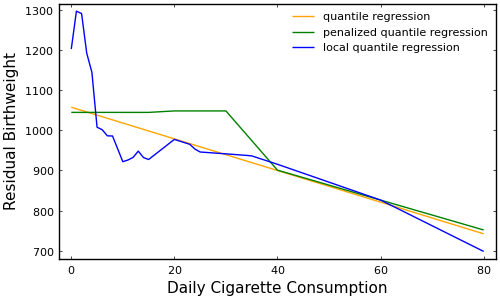

In [181]:
# Initialize plot
pyplot(size=(500,300), leg=true);

# Plot parameters
plt=plot(unq_D, qr_fitted, line = (:line, :line, 1, 1, :orange), label="quantile regression")
plot!(unq_D, pqr_fitted, line = (:line, :line, 1, 1, :green), label="penalized quantile regression")
plot!(unq_D, lqr_fitted, line = (:line, :line, 1, 1, :blue), label="local quantile regression")

# Additional formatting
plot!(legend=(0.5,0.75), framestyle = :box, grid=false, 
    background_color_legend = nothing)
ylabel!("Residual Birthweight")
xlabel!("Daily Cigarette Consumption")